# Imports

In [1]:
import datasets
import numpy as np
import pandas as pd
import keras
import transformers
import tensorflow as tf
import tqdm.notebook as tqdm
import sklearn.model_selection
import matplotlib.pyplot as plt

2024-11-20 22:18:54.197709: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-20 22:18:54.335193: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-20 22:18:55.200838: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except:
        print('e')

2024-11-20 22:19:00.477772: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-20 22:19:00.482753: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-20 22:19:00.482785: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
tf.__version__

'2.16.1'

In [4]:
BATCH_SIZE = 128
max_len_pad = 16

# Data

Load and prepare your dataset. Dataset should have at least 10k samples in it. Each dataset cannot be used by more than two students.

In [ ]:
dataset = datasets.load_dataset('stanfordnlp/sst2')

In [ ]:
dataset

In [ ]:
train_dataset = dataset['train']
eval_dataset = dataset['validation']
test_dataset = dataset['test']

In [ ]:
train_dataset.features

In [8]:
train_dataset['sentence']

['hide new secretions from the parental units ',
 'contains no wit , only labored gags ',
 'that loves its characters and communicates something rather beautiful about human nature ',
 'remains utterly satisfied to remain the same throughout ',
 'on the worst revenge-of-the-nerds clichés the filmmakers could dredge up ',
 "that 's far too tragic to merit such superficial treatment ",
 'demonstrates that the director of such hollywood blockbusters as patriot games can still turn out a small , personal film with an emotional wallop . ',
 'of saucy ',
 "a depressed fifteen-year-old 's suicidal poetry ",
 "are more deeply thought through than in most ` right-thinking ' films ",
 'goes to absurd lengths ',
 "for those moviegoers who complain that ` they do n't make movies like they used to anymore ",
 "the part where nothing 's happening , ",
 'saw how bad this movie was ',
 'lend some dignity to a dumb story ',
 'the greatest musicians ',
 'cold movie ',
 'with his usual intelligence and s

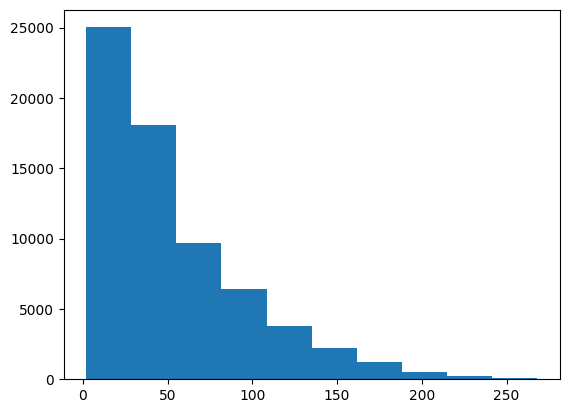

In [9]:
plt.hist([len(x) for x in train_dataset['sentence']])
plt.show()

# Backbone

Load pretrained model from Hugging Face (or some other model repository if it's more convenient). Model should be trained on Feature Extraction task.

In [96]:
base_model = transformers.TFAutoModel.from_pretrained('kamalkraj/deberta-base')

All model checkpoint layers were used when initializing TFDebertaModel.

All the layers of TFDebertaModel were initialized from the model checkpoint at kamalkraj/deberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDebertaModel for predictions without further training.


In [97]:
base_model

Load tokenizer to be used with the model

In [98]:
tokenizer = transformers.AutoTokenizer.from_pretrained('kamalkraj/deberta-base')

In [99]:
tokenizer

DebertaTokenizerFast(name_or_path='kamalkraj/deberta-base', vocab_size=50265, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	50264: AddedToken("[MASK]", rstrip=False, lstrip=True, single_word=False, normalized=True, special=True),
}

# Feature extraction

Since we will not be training the backbone, extract features from your dataset.

Tokenize all your sequences. Truncate/pad the squences for convenience. If the sequences are too large to be stored in memory, lazily save them on disk.

In [14]:
a = tokenizer(train_dataset['sentence'], return_tensors='np')

In [15]:
np.median(list(map(len, a['input_ids']))), np.max(list(map(len, a['input_ids'])))

(11.0, 67)

In [14]:
def pretokeniaer(dataset):
    return tokenizer(dataset['sentence'], truncation=True, padding=True, max_length=max_len_pad, return_tensors='np')

In [15]:
train_tokeniz = train_dataset.map(pretokeniaer, batched=True)

Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

In [14]:
train_tokeniz['input_ids']

[[1, 37265, 92, 3556, 2485, 31, 5, 20536, 2833, 1437, 2, 0, 0, 0, 0, 0],
 [1,
  10800,
  5069,
  117,
  22094,
  2156,
  129,
  6348,
  3995,
  821,
  8299,
  1437,
  2,
  0,
  0,
  0],
 [1,
  6025,
  6138,
  63,
  3768,
  8,
  39906,
  402,
  1195,
  2721,
  59,
  1050,
  2574,
  1437,
  2,
  0],
 [1, 5593, 5069, 19223, 10028, 7, 1091, 5, 276, 1328, 1437, 2, 0, 0, 0, 0],
 [1,
  261,
  5,
  2373,
  13543,
  12,
  1116,
  12,
  627,
  12,
  1396,
  11622,
  43848,
  5739,
  5,
  2],
 [1, 6025, 128, 29, 444, 350, 8805, 7, 13032, 215, 34501, 1416, 1437, 2, 0, 0],
 [1,
  34084,
  6031,
  1626,
  14,
  5,
  736,
  9,
  215,
  1368,
  9718,
  1803,
  32353,
  25,
  36409,
  2],
 [1, 1116, 2241, 257, 4469, 1437, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1,
  102,
  16658,
  23843,
  12,
  180,
  12,
  279,
  128,
  29,
  23630,
  14665,
  1437,
  2,
  0,
  0],
 [1,
  1322,
  55,
  4814,
  802,
  149,
  87,
  11,
  144,
  22209,
  235,
  12,
  22710,
  128,
  3541,
  2],
 [1, 2977, 293, 7, 16091, 18915

In [16]:
test_tokeniz = test_dataset.map(pretokeniaer, batched=True)
eval_tokeniz = eval_dataset.map(pretokeniaer, batched=True)

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Run the backbone on the sequences and save the extracted features. The extracted features should be a vector containing information about the whole text. If the features are too large to be stored in memory, lazily save them on disk.

In [17]:
all_tokeniz = np.concatenate([np.array(train_tokeniz['input_ids']), np.array(eval_tokeniz['input_ids'])], axis=0)

In [42]:
def extract_features(model, tokenized_input):
    input_tensor = tf.constant(tokenized_input, dtype=tf.int32)
    
    outputs = model(input_tensor)
    outputs = keras.ops.max(outputs.last_hidden_state, axis=1)
    
    return outputs

In [43]:
all_features = []


for i in range(0, len(all_tokeniz), BATCH_SIZE):

    batch = all_tokeniz[i:i + BATCH_SIZE]
    
    features = extract_features(base_model, batch)
    
    all_features.append(features.numpy())


all_features = np.concatenate(all_features, axis=0)

print("Размер признаков:", all_features.shape)

Размер признаков: (68221, 768)


In [44]:
len(all_features)

68221

In [45]:
with open("extracted_features2.npy", 'wb') as f:
    np.save(f, all_features)

# Prepare train/test data

Split your data (extracted features and labels) into train and test subsets.

In [46]:
all_labels = np.concatenate([np.array(train_dataset['label']), np.array(eval_dataset['label'])], axis=0)

In [47]:
np.save('labels2.npy', all_labels)

In [6]:
with open("extracted_features2.npy", 'rb') as f:
    all_features = np.load(f)

In [7]:
all_labels = np.load('labels2.npy')

In [8]:
all_features.shape, all_labels.shape

((68221, 768), (68221,))

In [9]:
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(all_features, all_labels, test_size=0.3, random_state=747, shuffle=True)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((47754, 768), (20467, 768), (47754,), (20467,))

Prepare `tf.data.Dataset` or some other way for the data to be used during training.

In [10]:
dataset_train = tf.data.Dataset.zip(tf.data.Dataset.from_tensor_slices(X_train),
                                    tf.data.Dataset.from_tensor_slices(y_train)).batch(BATCH_SIZE)

2024-11-20 22:20:59.360811: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-20 22:20:59.360975: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-20 22:20:59.360997: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-20 22:20:59.704630: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-20 22:20:59.704730: I external/local_xla/xla/stream_executor

In [11]:
dataset_train

<_BatchDataset element_spec=(TensorSpec(shape=(None, 768), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [12]:
X, y = next(iter(dataset_train))

In [13]:
X

<tf.Tensor: shape=(128, 768), dtype=float32, numpy=
array([[1.0978289 , 0.05845261, 0.28679532, ..., 1.3350065 , 0.6543642 ,
        1.2030916 ],
       [1.0914017 , 1.2294528 , 0.5650454 , ..., 1.2087369 , 1.2807348 ,
        1.3382752 ],
       [0.8732379 , 1.543327  , 0.4063105 , ..., 1.642583  , 0.50368124,
        0.9682008 ],
       ...,
       [0.58982253, 2.1943233 , 0.40944034, ..., 1.7299528 , 0.21366018,
        1.2046604 ],
       [1.2787602 , 0.6527308 , 0.4853236 , ..., 2.0593722 , 1.3980544 ,
        1.5843303 ],
       [1.1280006 , 2.203532  , 0.53642184, ..., 1.5041952 , 0.21455325,
        1.2509826 ]], dtype=float32)>

In [14]:
y

<tf.Tensor: shape=(128,), dtype=int64, numpy=
array([1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])>

In [15]:
dataset_val = tf.data.Dataset.zip(tf.data.Dataset.from_tensor_slices(X_val),
                                    tf.data.Dataset.from_tensor_slices(y_val)).batch(BATCH_SIZE)

# Build the model

Build a simple model. The model should accept an extracted feature vector and return a vector of class logits (or probabilities). Model should only have a couple (or even 1) layer with weights.

In [72]:
inputs = tf.keras.layers.Input((768,), dtype=tf.float32, name='input')
x = tf.keras.layers.Dense(128, activation='relu', name='danse1')(inputs)
outputs = tf.keras.layers.Dense(1, activation='sigmoid', name='predict')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs, name='classifier_text')

In [73]:
model.summary()

Model: "classifier_text"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ danse1 (Dense)                  │ (None, 128)            │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predict (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,561 (385.00 KB)

 Trainable params: 98,561 (385.00 KB)

 Non-trainable params: 0 (0.00 B)

Compile the model. Choose loss and metrics.

In [74]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy'])

# Train the model

In [75]:
history = model.fit(dataset_train, validation_data=dataset_val, batch_size=BATCH_SIZE, epochs=30)

Epoch 1/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6865 - loss: 0.6279 - val_accuracy: 0.8083 - val_loss: 0.4242
Epoch 2/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8083 - loss: 0.4225 - val_accuracy: 0.8195 - val_loss: 0.4006
Epoch 3/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8170 - loss: 0.4053 - val_accuracy: 0.8149 - val_loss: 0.4007
Epoch 4/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8216 - loss: 0.3957 - val_accuracy: 0.8177 - val_loss: 0.3957
Epoch 5/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8255 - loss: 0.3887 - val_accuracy: 0.8193 - val_loss: 0.3926
Epoch 6/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8283 - loss: 0.3822 - val_accuracy: 0.8213 - val_loss: 0.3883
Epoch 7/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8306 - loss: 0.3769 - val_accuracy: 0.8213 - val_loss: 0.3891
Epoch 8/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8337 - loss: 0.3725 - val_accuracy: 0.

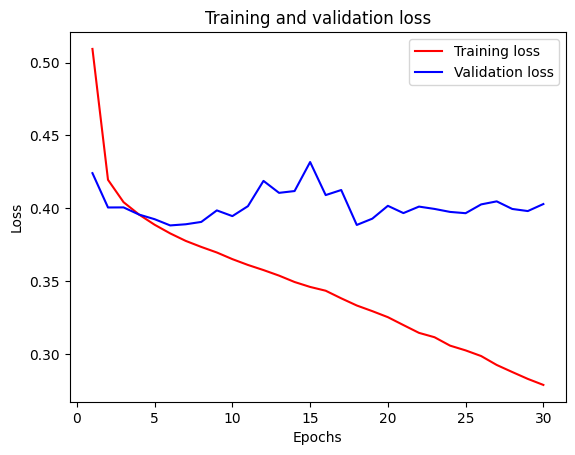

In [76]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss',)
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

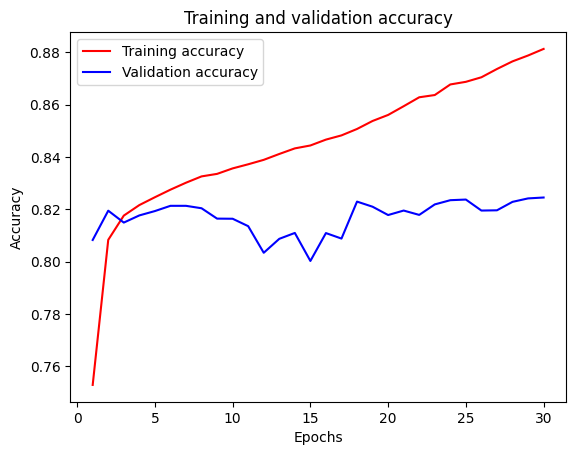

In [77]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [78]:
history2 = model.fit(dataset_train, validation_data=dataset_val, batch_size=BATCH_SIZE, epochs=30)

Epoch 1/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8833 - loss: 0.2726 - val_accuracy: 0.8245 - val_loss: 0.4018
Epoch 2/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8857 - loss: 0.2696 - val_accuracy: 0.8190 - val_loss: 0.4244
Epoch 3/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8879 - loss: 0.2643 - val_accuracy: 0.8164 - val_loss: 0.4254
Epoch 4/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8903 - loss: 0.2600 - val_accuracy: 0.8152 - val_loss: 0.4369
Epoch 5/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8929 - loss: 0.2563 - val_accuracy: 0.8196 - val_loss: 0.4303
Epoch 6/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8930 - loss: 0.2537 - val_accuracy: 0.8196 - val_loss: 0.4396
Epoch 7/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8964 - loss: 0.2489 - val_accuracy: 0.8261 - val_loss: 0.4217
Epoch 8/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8970 - loss: 0.2459 - val_accuracy: 0.

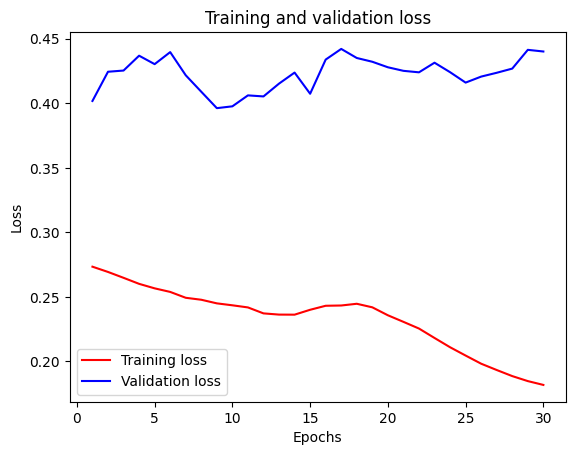

In [79]:
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss',)
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

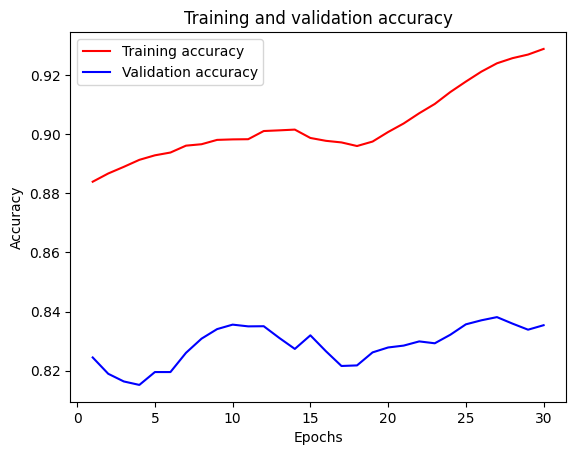

In [80]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [81]:
model.save_weights(f'second_{model.name}.weights.h5')
print(f'Веса модели {model.name} сохранены')

Веса модели classifier_text сохранены


# Evaluation

Evalute the model on test data.

In [12]:
model.load_weights('second_classifier_text.weights.h5')

In [82]:
model.evaluate(dataset_val)

160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8391 - loss: 0.4294


[0.44011390209198, 0.8353935480117798]

Plot confusion matrix.

In [83]:
y_val = []
for _, y in dataset_val:
    y_val.append(np.array(y))

2024-11-20 22:40:58.068395: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [84]:
y_val = np.concatenate(y_val, axis=0)

In [85]:
y_pred = model.predict(dataset_val)

160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [86]:
y_pred

array([[0.823812  ],
       [0.16638763],
       [0.01097303],
       ...,
       [0.99989307],
       [0.9762265 ],
       [0.9985751 ]], dtype=float32)

In [87]:
y_val

array([0, 0, 0, ..., 1, 1, 1])

In [88]:
y_pred = np.round(y_pred.flatten()).astype(int)
y_pred

array([1, 0, 0, ..., 1, 1, 1])

In [89]:
np.unique(y_pred), np.unique(y_val)

(array([0, 1]), array([0, 1]))

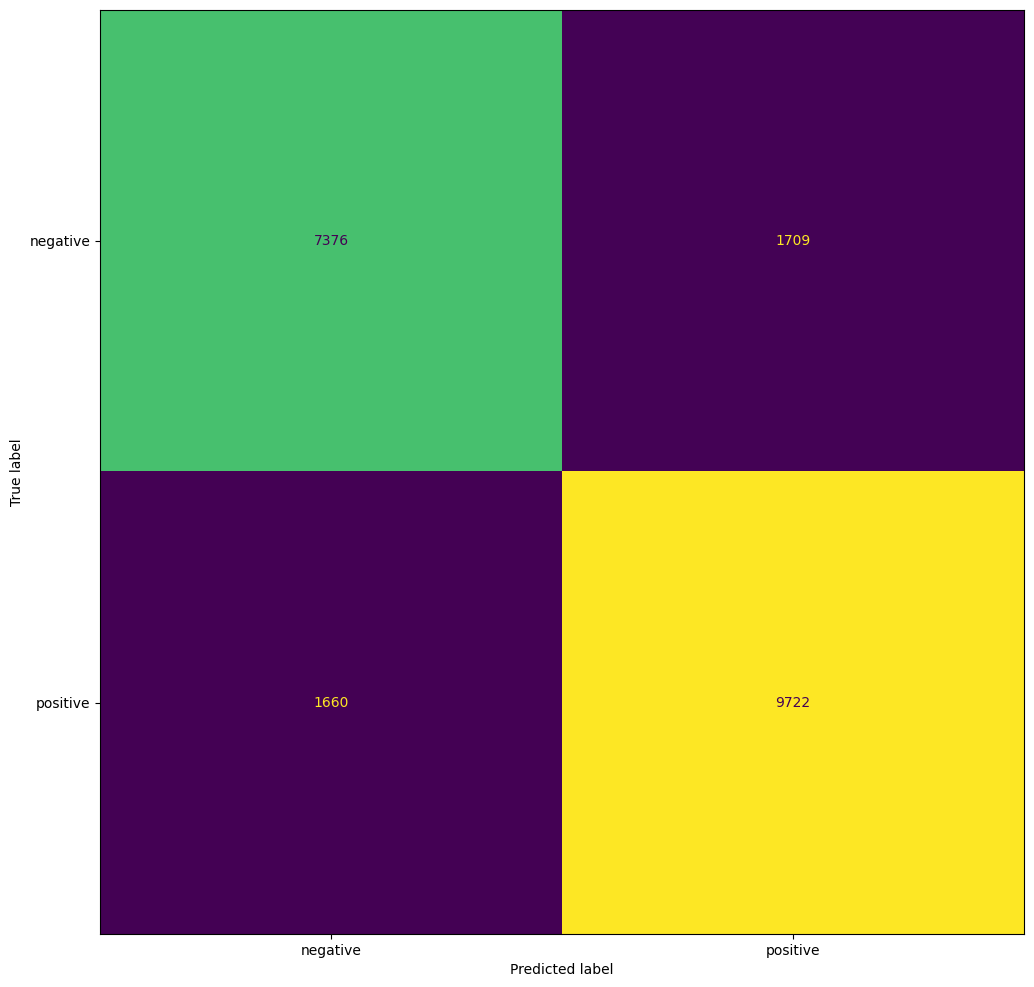

In [90]:
_, ax = plt.subplots(figsize=(12, 12))
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_val, y_pred, labels=[0, 1],display_labels=['negative', 'positive'], ax=ax, colorbar=False)

Write a function to classify a piece of text.

In [102]:
def classify_text(text: str,
                  treshold: int = 0.5) -> tuple[int | str, np.ndarray]:
    '''Classifes the given `text` using the trained model.

    Arguments:
        text: text to be classified

    Return:
        The assigned label and probabilites of all labels'''

    text_tokeniz = tokenizer(text, truncation=True, padding='max_length', max_length=max_len_pad, return_tensors='tf')

    features = keras.ops.max(base_model(text_tokeniz['input_ids']).last_hidden_state, axis=1)

    predict = model.predict(features, verbose=False)

    label = 1 if predict[0][0] >= treshold else 0
    probability = np.round(predict[0][0], 5)

    return label, probability

Evaluate the model on text not present in training and test data (come up with the text yourself). Try to get an input for each class.

In [92]:
test_dataset = datasets.load_dataset('stanfordnlp/sst2', split='test')

In [93]:
max_len_pad

16

In [94]:
labels = ['nagative', 'positive']

In [103]:
text = test_dataset['sentence'][89]
print(text)
label, probability = classify_text(text, treshold=0.5)
print(f'Это {labels[label]} комментарий')
print(f'Вероятность принадлежности текста к классу positive: {probability}') 

i 'm not suggesting that you actually see it , unless you 're the kind of person who has seen every wim wenders film of the '70s .
Это nagative комментарий
Вероятность принадлежности текста к классу positive: 0.2839600145816803


In [104]:
text = test_dataset['sentence'][5]
print(text)
label, probability = classify_text(text, treshold=0.5)
print(f'Это {labels[label]} комментарий')
print(f'Вероятность принадлежности текста к классу positive: {probability}') 

a well-made and often lovely depiction of the mysteries of friendship .
Это positive комментарий
Вероятность принадлежности текста к классу positive: 1.0


In [105]:
for i in range(1030, 1070, 5):
    text = test_dataset['sentence'][i]
    print(30*'-')
    print(text)
    label, probability = classify_text(text, treshold=0.5)
    print(f'Это {labels[label]} комментарий')
    print(f'Вероятность принадлежности текста к классу positive: {probability}') 

------------------------------
you might not buy the ideas .
Это nagative комментарий
Вероятность принадлежности текста к классу positive: 0.034630000591278076
------------------------------
... surprisingly inert for a movie in which the main character travels back and forth between epochs .
Это positive комментарий
Вероятность принадлежности текста к классу positive: 0.9035900235176086
------------------------------
finds a way to tell a simple story , perhaps the simplest story of all , in a way that seems compelling and even original .
Это positive комментарий
Вероятность принадлежности текста к классу positive: 0.6971700191497803
------------------------------
city by the sea is the cinematic equivalent of defensive driving : it 's careful , conscientious and makes no major mistakes .
Это positive комментарий
Вероятность принадлежности текста к классу positive: 0.7329599857330322
------------------------------
gets under the skin of a man who has just lost his wife .
Это positive 

# Bonus

Write a function that computes word impact on text label. 

In [106]:
def get_words_impact(text: str) -> list[tuple[str, np.ndarray]]:
    '''Determines word impact on text label.

    Arguments:
        text: Sample text to be used for computation.

    Returns:
        A list of pairs: the word and vector of probability changes for each class'''
    pairs = {}
    pairs['full_text'] = classify_text(text)[1]
    all_words = text.split()
    for word in all_words:
        del_words = [x for x in all_words if x != word]
        new_text = ' '.join(del_words)
        pairs[word] = classify_text(new_text)[1]
        
    return list(pairs.items())

Try to find out words that make text have a specific label.

In [107]:
text = "I was very impressed by the thoughtfulness of the film's script ."
get_words_impact(text)

[('full_text', 1.0),
 ('I', 1.0),
 ('was', 1.0),
 ('very', 1.0),
 ('impressed', 0.99998),
 ('by', 1.0),
 ('the', 1.0),
 ('thoughtfulness', 0.99999),
 ('of', 1.0),
 ("film's", 1.0),
 ('script', 1.0),
 ('.', 1.0)]

In [108]:
text = "This movie is one big cliche"
get_words_impact(text)

[('full_text', 0.0),
 ('This', 0.00253),
 ('movie', 6e-05),
 ('is', 0.00018),
 ('one', 1e-05),
 ('big', 0.00125),
 ('cliche', 0.99899)]

In [109]:
text = "I think the author didn't have enough skills to make the film more interesting ."
get_words_impact(text)

[('full_text', 2e-05),
 ('I', 1e-05),
 ('think', 0.00167),
 ('the', 1e-05),
 ('author', 0.00114),
 ("didn't", 0.82746),
 ('have', 2e-05),
 ('enough', 1e-05),
 ('skills', 3e-05),
 ('to', 0.00035),
 ('make', 0.00061),
 ('film', 0.0),
 ('more', 6e-05),
 ('interesting', 2e-05),
 ('.', 2e-05)]

In [110]:
text = "I was very interested ."
get_words_impact(text)

[('full_text', 0.98699),
 ('I', 0.99979),
 ('was', 0.99127),
 ('very', 0.93957),
 ('interested', 0.49792),
 ('.', 0.99886)]

In [111]:
text = "gets under the skin of a man who has just lost his wife ."
get_words_impact(text)

[('full_text', 0.80235),
 ('gets', 0.58142),
 ('under', 0.14517),
 ('the', 0.63127),
 ('skin', 0.95712),
 ('of', 0.9273),
 ('a', 0.72881),
 ('man', 0.73443),
 ('who', 0.19942),
 ('has', 0.64821),
 ('just', 0.34552),
 ('lost', 0.8571),
 ('his', 0.90824),
 ('wife', 0.07147),
 ('.', 0.74825)]

In [112]:
text = "finds a way to tell a simple story , perhaps the simplest story of all , in a way that seems compelling and even original ."
get_words_impact(text)

[('full_text', 0.69717),
 ('finds', 0.76927),
 ('a', 0.95714),
 ('way', 0.8065),
 ('to', 0.70071),
 ('tell', 0.50262),
 ('simple', 0.77711),
 ('story', 0.98655),
 (',', 0.82163),
 ('perhaps', 0.98012),
 ('the', 0.89097),
 ('simplest', 0.84839),
 ('of', 0.69717),
 ('all', 0.69717),
 ('in', 0.69717),
 ('that', 0.69717),
 ('seems', 0.69717),
 ('compelling', 0.69717),
 ('and', 0.69717),
 ('even', 0.69717),
 ('original', 0.69717),
 ('.', 0.69717)]